In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import argparse

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

print('###Starting script###')
print('torch version: {}'.format(torch.__version__))
print('Number CUDA Devices: {}'.format(torch.cuda.device_count()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


n_epochs = 100
batch_size = 16

print('batch size: {}'.format(batch_size))
print('epochs: {}'.format(n_epochs))


class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)
        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        
        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
        
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, z_size, output_size, dropout_p):
        super(Model, self).__init__()
        self.dropout_p = dropout_p

        self.h1 = nn.Linear(input_size, hidden_size)
        self.z  = nn.Linear(hidden_size, z_size)
        self.h2 = nn.Linear(z_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.h1(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.z(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.leaky_relu(self.h2(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.h3(x)
        return x
        
class Initializer:
    # to apply xavier_uniform:
    #Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
    # or maybe normal distribution:
    #Initializer.initialize(model=net, initialization=init.normal_, mean=0, std=0.2)
    def __init__(self):
        pass

    @staticmethod
    def initialize(model, initialization, **kwargs):
        def weights_init(m):
            if isinstance(m, nn.Linear):
                initialization(m.weight.data, **kwargs)
                try:
                    initialization(m.bias.data)
                except:
                    pass
        model.apply(weights_init)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




###Starting script###
torch version: 0.4.0
Number CUDA Devices: 0
batch size: 16
epochs: 100


In [15]:
#Datasets
training_dataset = z24Dataset(mode='training', window_size=100, normalize=True)
training_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=4)

validating_dataset = z24Dataset(mode='validating', window_size=100, normalize=True)
validating_dataloader = DataLoader(validating_dataset, batch_size=1, shuffle=True, num_workers=4)

testing_dataset = z24Dataset(mode='testing', window_size=100, normalize=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=634, shuffle=False, num_workers=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = torch.load(f='../results/trained_autoencoder_memmap.pt',map_location='cpu')

/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [17]:
X,Y = next(iter(testing_dataloader))


In [18]:
%%time
model(X.float())

CPU times: user 218 ms, sys: 17 ms, total: 235 ms
Wall time: 157 ms


tensor([[ 2.5699e+00, -1.6445e-01,  2.0547e-03,  ..., -8.4890e-02,
          1.5854e-01,  3.8040e-01],
        [ 2.3909e+00, -1.7431e-01, -4.1626e-02,  ...,  2.1149e-01,
         -4.8462e-02,  1.4342e-01],
        [ 2.0189e+00, -9.9775e-02,  9.1453e-03,  ...,  6.2403e-02,
          4.2836e-02,  8.2248e-02],
        ...,
        [ 2.5001e+00, -1.0822e-01, -9.3936e-02,  ..., -7.7060e-02,
         -7.8255e-02,  3.7694e-01],
        [ 2.5455e+00, -4.8177e-02, -2.0950e-02,  ...,  5.3569e-02,
         -2.7371e-02,  3.2364e-01],
        [ 2.4893e+00, -1.4452e-01, -4.3419e-02,  ...,  2.5160e-03,
          6.0033e-02,  3.0688e-02]])

In [19]:
index = 5999
X, Y = training_dataset[index]
test=model(torch.tensor(X).float())

In [20]:
N = 1000
results = np.zeros([N,700])

for i in range(N):
    results[i,:] = model(torch.tensor(X).float()).detach().numpy()[0]


In [21]:
results_mean = np.mean(results, axis=0)
results_std  = np.std(results, axis=0)

In [22]:
true_y = Y[0,:]#.detach().numpy()

true_y_vib = np.reshape(true_y, [7,100])
yhat = model(X.float())[0,:].detach().numpy()

y_hat=np.reshape(yhat, [7,100])

plt.figure(figsize=(20,2))
plt.plot(true_y_vib[0], label='True')
plt.plot(y_hat[0], label='Predicted')

IndexError: too many indices for array

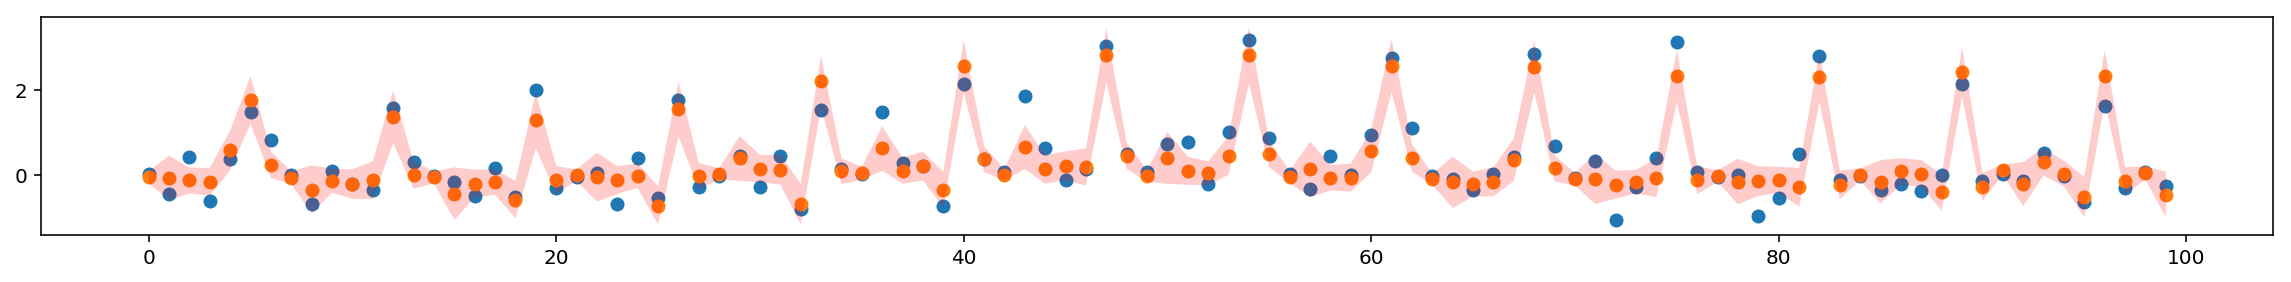

In [25]:
y_hat_mean=np.reshape(results_mean, [7,100])
y_hat_std = np.reshape(results_std, [7,100])

plt.figure(figsize=(20,2))
plt.scatter(range(100),true_y_vib[1], label='True')
plt.scatter(range(100),y_hat_mean[1], label='Predicted')
plt.fill_between(range(100), y_hat_mean[1]-2*y_hat_std[1], y_hat_mean[1]+2*y_hat_std[1], 
                 facecolor='red', interpolate=True, alpha=0.2)

NameError: name 'y_vib' is not defined

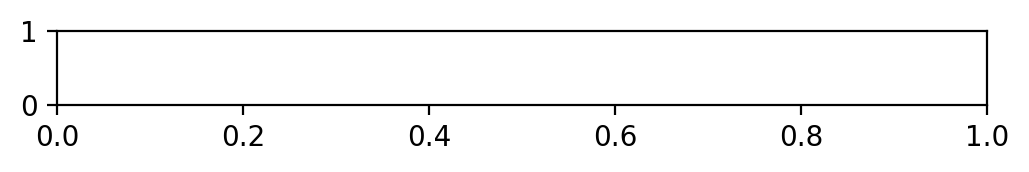

In [32]:

plt.figure(dpi=100)
plt.title('One pass')

for i in range(1,8):
    
    plt.subplot(int('71'+str(i)))
    plt.plot(y_vib[i-1,:],label='true')
    plt.plot(y_hat[i-1,:],label='predicted')
plt.legend()

In [26]:
x,y = training_dataset[433]